In [15]:
import pandas as pd
import numpy as np
import rospy
import rosbag
import rospkg
import os
from sklearn import mixture
from joblib import dump, load
import matplotlib.pyplot as plt


# Initialize member variables
rospack = rospkg.RosPack()
pkg_path = rospack.get_path('hri_audition')
wav_path = pkg_path + '/data/wav/'
feat_path = pkg_path + '/data/features/'
model_path = pkg_path + '/data/models/'

mfcc_cols = ['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12']

In [22]:
cov_type='full'
n_components = np.arange(1,40)

def train_gmm(X_train, gmm_comps, gmm_cov):
        clf = mixture.GaussianMixture(n_components=gmm_comps, covariance_type=gmm_cov)
        clf.fit(X_train)
        return clf

def train_and_save_gmms():
    print('Training and saving GMMs')

    # Ensure output directories exist
    if os.path.exists(model_path)==False:
        os.mkdir(model_path)

    for sound_type in ['voice','scene']:
        full_dir = os.path.join(model_path,sound_type)
        if os.path.exists(full_dir)==False:
            os.mkdir(full_dir)

    # Iterate through dataframes/.csvs, train models, and save them
    for root, dirs, files in os.walk(feat_path,topdown=True):
        for file in files:
            filepath = os.path.join(root,file)

            # Get type label of datafile
            type_dir = os.path.dirname(filepath)
            type_str = os.path.split(type_dir)[-1]

            # Get class label of datafile
            base = os.path.splitext(file)[0]
            ext = os.path.splitext(file)[-1]

            if ext =='.csv':
                print(base)
                sav_path = os.path.join(model_path,type_str)

                # Get training data for this voice ID
                data_df = pd.read_csv(filepath,index_col=0)
                X = data_df.loc[:,mfcc_cols].to_numpy()
                
                models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
                          for n in n_components]
                plt.plot(n_components, [m.bic(X) for m in models], '--', label='BIC')
                plt.plot(n_components, [m.aic(X) for m in models], '-', label='AIC')
                plt.legend(loc='best')
                plt.xlabel('n_components');


Training and saving GMMs
john
justin
christina
pickleoutside
lab


/home/jd/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


eme


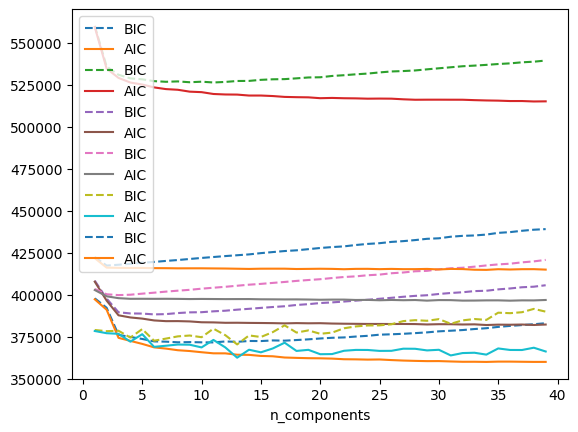

In [23]:
train_and_save_gmms()

# Testing trained classifiers

In [28]:
clfs = []
clf_names = []

for root, dirs, files in os.walk(model_path,topdown=True):
    
    for file in files:
        filepath = os.path.join(root,file)
        
        # Get type label of datafile
        type_dir = os.path.dirname(filepath)
        type_str = os.path.split(type_dir)[-1]

        # Get base filename and class label of datafile
        base = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[-1]
              
        if type_str=='voice' and ext=='.joblib':
            # Load this model and add to classifiers list
            clfs.append(load(filepath))
            clf_names.append(base)

In [32]:
# Lab MFCC
mfcc = np.array([[74.39020538330078, -10.577116012573242, 22.609766006469727, 5.6713714599609375, 11.7103271484375, 2.787160873413086, -4.6597795486450195, 8.03140640258789, 11.714319229125977, 0.42456817626953125, 5.001497268676758, 1.0622801780700684]])

# Justin MFCC
mfcc = np.array([[64.13141632080078, -28.730426788330078, 5.33988094329834, -13.051506042480469, 10.666414260864258, 0.2029743194580078, 7.005288600921631, -3.445453643798828, 9.986784934997559, -13.093144416809082, -13.05609130859375, 7.512784957885742]])

# John MFCC
mfcc = np.array([[92.48063659667969, -28.43824005126953, -1.444969654083252, -5.370695114135742, 4.418185234069824, 17.393238067626953, 5.924343109130859, 12.867308616638184, 14.365715026855469, -8.615602493286133, -11.447735786437988, -14.660947799682617]])


print(mfcc)
print()
for ii in range(len(clfs)):
    clf = clfs[ii]
    label = clf_names[ii]
    
    print(label)

#     print(clf.covariances_)
    print('prob')
    prob = clf.predict_proba(mfcc)
    print(prob)
    print(prob.sum())
    
    print('weighted prob')
    w_prob = np.multiply(prob,clf.weights_)
    print(w_prob)
    print(np.multiply(clf.predict_proba(mfcc),clf.weights_).sum())
    
    print('score')
    score = clf.score(mfcc)
    print(score)

    print()
    print()

[[ 92.4806366  -28.43824005  -1.44496965  -5.37069511   4.41818523
   17.39323807   5.92434311  12.86730862  14.36571503  -8.61560249
  -11.44773579 -14.6609478 ]]

justin
prob
[[1.26179674e-020 2.02864337e-123 2.38718429e-030 1.05997602e-102
  5.92820138e-021 2.62238928e-052 2.37130877e-016 2.75523823e-008
  9.05696149e-179 9.99991850e-001 2.45538078e-171 2.08067824e-010
  7.29747909e-037 2.16393237e-025 1.96578279e-019 3.64737912e-019
  2.68798614e-035 4.63762612e-016 4.01325421e-006 4.16749455e-020
  5.44445081e-048 4.26500148e-087 2.37423997e-007 2.29284850e-023
  1.77211210e-021 7.06411841e-011 1.56535433e-012 3.14105080e-014
  3.84948523e-013 2.21407351e-012 3.87133067e-006 2.48332666e-034]]
0.999999999999999
weighted prob
[[2.80218654e-022 2.51647695e-124 6.06017394e-032 9.65164669e-104
  1.39336511e-022 4.06328007e-054 7.16609034e-018 6.83329602e-010
  1.98970367e-180 1.83087317e-002 3.99935303e-172 3.08260314e-012
  4.23672872e-038 4.42474661e-027 6.55765990e-021 4.44240167e-0